In [1]:
import json
import sys
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import scipy.stats as stats
import random
from scipy.stats import gaussian_kde, loguniform
from math import lgamma
from glob import glob
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

path = '/Users/chris/Desktop/sculpting/syssim-tests/'

Read in SysSimExClusters simulated physical and observed catalogs, as prescribed in https://github.com/ExoJulia/SysSimExClusters/tree/He_et_al_2020b. Re: observed data - this is another potential point of divergence, alongside the ground truth data and the physical catalog. 

In [2]:
phys_cat = pd.read_csv(path+'physical_catalogs/physical_catalog1.csv', 
                       header=0, sep=',', skiprows=26) # first 26 lines are column descriptors
print(phys_cat)

        target_id  star_id  planet_mass  planet_radius  clusterid      period  \
0             1.0  32722.0     0.000024       0.036591        1.0   13.033967   
1             1.0  32722.0     0.000012       0.023100        1.0   24.570980   
2             1.0  32722.0     0.000010       0.017899        1.0   33.749414   
3             1.0  32722.0     0.000042       0.025463        1.0   73.674940   
4             1.0  32722.0     0.000039       0.031153        1.0  172.771079   
...           ...      ...          ...            ...        ...         ...   
252291    86759.0  34287.0     0.000009       0.012245        1.0   51.553007   
252292    86759.0  34287.0     0.000009       0.022599        1.0   79.116959   
252293    86759.0  34287.0     0.000017       0.025012        2.0  153.167410   
252294    86759.0  34287.0     0.000027       0.017018        2.0  255.917742   
252295    86760.0  45485.0     0.000002       0.008163        1.0  201.536036   

             ecc      incl 

In [3]:
phys_cat2 = pd.read_csv(path+'physical_catalogs/physical_catalog2.csv', 
                       header=0, sep=',', skiprows=26) # first 26 lines are column descriptors
#print(phys_cat2)

In [4]:
phys_cat3 = pd.read_csv(path+'physical_catalogs/physical_catalog3.csv', 
                       header=0, sep=',', skiprows=26) # first 26 lines are column descriptors
#print(phys_cat3)

In [5]:
obs_cat1 = pd.read_csv(path+'observed_catalogs/observed_catalog1.csv', 
                       header=0, sep=',', skiprows=26) # first 26 lines are column descriptors
print(obs_cat1)
print(obs_cat1.groupby('target_id').size().reset_index(name='counts').groupby('counts').size())

      target_id  star_id      period  period_err     depth  depth_err  \
0          65.0  77706.0    4.301932    0.000416  0.001497   0.000026   
1          98.0  66894.0  120.710912    0.003452  0.000407   0.000025   
2         113.0  22051.0   10.081561    0.002077  0.000363   0.000022   
3         387.0  17795.0   21.456983    0.000828  0.000697   0.000012   
4         462.0  13840.0   27.861821    0.002702  0.000225   0.000020   
...         ...      ...         ...         ...       ...        ...   
2064    56482.0  42623.0    8.499573    0.000618  0.001051   0.000018   
2065    56482.0  42623.0   19.013656    0.000753  0.001277   0.000023   
2066    56482.0  42623.0   48.988708    0.001056  0.001767   0.000036   
2067    56482.0  42623.0  104.380900    0.000596  0.005725   0.000043   
2068    56482.0  42623.0  223.879852    0.002676  0.001660   0.000055   

      duration  duration_err  star_mass  star_radius  
0     0.083454      0.000971      0.778        0.745  
1     0.30262

In [6]:
obs_cat2 = pd.read_csv(path+'observed_catalogs/observed_catalog2.csv', 
                       header=0, sep=',', skiprows=26) # first 26 lines are column descriptors
print(len(obs_cat2))

2080


In [7]:
obs_cat3 = pd.read_csv(path+'observed_catalogs/observed_catalog3.csv', 
                       header=0, sep=',', skiprows=26) # first 26 lines are column descriptors
print(len(obs_cat3))

2328


Run it through my likelihood pipeline

In [8]:
def better_loglike(lam, k):
    """
    Calculate Poisson log likelihood
    Changed 0 handling from simulate.py to reflect https://www.aanda.org/articles/aa/pdf/2009/16/aa8472-07.pdf
    """

    logL = []
    #print(lam)
    for i in range(len(lam)):
        if lam[i]==0:    
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = 0
            logL.append(term1+term2+term3)
        else:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = k[i]*np.log(lam[i])
            logL.append(term1+term2+term3)

    return np.sum(logL)

def calculate_sn(P, rp, rs, cdpp, tdur): 
    """
    Calculate S/N per planet using Eqn 4 in Christiansen et al 2012: https://arxiv.org/pdf/1208.0595.pdf
    
    Params: P (days); rp (Earth radii); rs (Solar radii); cdpp (ppm); tdur (days)
    
    Returns: S/N
    """
    tobs = 365*3.5 # days; time spanned observing the target; set to 3.5 years, or the length of Kepler mission
    f0 = 0.92 # fraction of time spent actually observing and not doing spacecraft things
    tcdpp = 0.25 # days; using CDPP for 6 hour transit durations; could change to be more like Earth transiting Sun?
    rp = earth_radius_to_au(rp)
    rs = solar_radius_to_au(rs)
    #print(P, rp, rs, cdpp, tdur)
    
    factor1 = np.sqrt(tobs*f0/np.array(P)) # this is the number of transits
    delta = 1e6*(rp/rs)**2 # convert from parts per unit to ppm
    cdpp_eff = cdpp * np.sqrt(tcdpp/tdur)
    factor2 = delta/cdpp_eff
    sn = factor1 * factor2
    #print(factor1, delta, cdpp_eff, sn)

    return sn

def loglike_direct_draw_better(cube, ndim, nparams, k):
    """
    Run model per hyperparam draw and calculate Poisson log likelihood
    2nd iteration of bridge function between model_direct_draw() and better_logllike()
    Includes geometric transit multiplicity and 0 handling.
    Commented out the zero handling because it's wrong.

    Params: 
    - cube: hyperparam cube of slope and intercept
    - ndim: number of dimensions
    - nparams: number of parameters
    - k: from Berger et al 2020
    Returns: Poisson log-likelihood
    """

    # retrieve prior cube and feed prior-normalized hypercube into model to generate transit multiplicities
    lam, geom_lam, transits, intact_fractions, amds, eccentricities, inclinations_degrees = model_direct_draw(cube)
    #lam = [1e-12 if x==0.0 else x for x in lam] # avoid -infs in logL by turning 0 lams to 1e-12
    #geom_lam = [1e-12 if x==0.0 else x for x in geom_lam] # ditto
    logL = better_loglike(lam, k)
    geom_logL = better_loglike(geom_lam, k)
    
    return logL, lam, geom_lam, geom_logL, transits, intact_fractions, amds, eccentricities, inclinations_degrees

def model_direct_draw(cube):
    """
    Take prior and draw systems out of Kepler data 
    Params: n-dim hypercube prior
    Returns: lambdas and simulated transit DataFrame
    """
    # retrieve prior
    #print(cube)
    m, b, cutoff = cube[0], cube[1], cube[2]
    
    kepids = []
    midplanes = []
    midplanes_degrees = []
    inclinations = []
    inclinations_degrees = []
    eccentricities = []
    long_periastrons = []
    planets_per_case2 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
    planets_a_case2 = []
    star_radius = []
    star_mass = []
    impact_parameters = []
    transit_status1 = []
    transit_status2 = []
    transit_statuses = []
    transit_multiplicities = []
    geometric_transit_multiplicity = []
    tdurs = []
    jmags = []
    sns = []
    prob_detections = []
    xi = []
    xi_old = []
    xi_young = []
    prob_intacts = []
    amds = []
    num_planets_all = []
    intacts = 0
    
    # draw ~20000 systems
    num_samples = len(berger_kepler)
    #num_samples = 100
    for i in range(len(berger_kepler[0:num_samples])):
    #for i in range(10):
        ### star ###
        kepids.append(berger_kepler.kepid[i])
        r_star = berger_kepler.iso_rad[i] # in solar radii
        m_star = berger_kepler.iso_mass[i] # in solar masses
        age_star = berger_kepler.iso_age[i]
        mu = list(np.random.uniform(-np.pi/2,np.pi/2,1)) # create midplane for star 
        midplanes.append(mu)
        midplanes_degrees.append([mu_elt*180/np.pi for mu_elt in mu])
        cdpp = berger_kepler.rrmscdpp06p0[i] # don't convert from ppm to parts per unit

        ### planet ###
        r_planet = 2. # use two Earth radii; will make negligible difference
        m_planet = 5. # from Chen & Kipping 2016
        
        """
        # calculate probability given age using piecewise model
        #print("m, b, cutoff: ", m, b, cutoff)
        #print("age star: ", age_star)
        if age_star < cutoff: # if decay cutoff hasn't occurred yet, follow decay model
            prob = m * age_star + b
        else: # if decay cutoff has occurred, use P(intact) at time when cutoff occurred
            prob = m * cutoff + b 
        """

        """
        # not including piecewise/cutoff model
        prob = m * age_star + b

        if prob < 0.: # don't allow negative probabilities
            prob = 0.
        """

        prob = compute_prob2(age_star, m, b, cutoff)
        prob_intacts.append(prob)
        intact_flag = np.random.choice(['intact', 'disrupted'], p=[prob, 1-prob])
        if intact_flag == 'intact':
            intacts += 1
            # young system has 5 or 6 planets
            num_planets = random.choice([5, 6]) 
            sigma = np.pi/90 # 2 degrees, per Fig 6 in Fabrycky 2012
            eccentricity = calculate_eccentricity(num_planets)
            long_periastron = np.random.uniform(0,2*np.pi,1) # or do I draw num_planet omegas?
            
            # simulate transit-related characteristics for 5 or 6 planets
            planet_a_case2, inclination_degrees = sim_transits_new(r_star, m_star, num_planets, mu, sigma, r_planet, age_star, eccentricity, long_periastron,
                             planets_per_case2 = planets_per_case2, planets_a_case2 = planets_a_case2, 
                             inclinations = inclinations, inclinations_degrees = inclinations_degrees,
                             impact_parameters = impact_parameters, transit_statuses = transit_statuses, 
                             transit_status1 = transit_status1, transit_status2 = transit_status2, 
                             transit_multiplicities = transit_multiplicities, tdurs = tdurs,
                             cdpp = cdpp, sns = sns, prob_detections = prob_detections, 
                             geometric_transit_multiplicity = geometric_transit_multiplicity)

        elif intact_flag == 'disrupted':
            # old system has 1 or 2 planets
            num_planets = random.choice([1, 2]) 
            sigma = np.pi/22.5 # 8 degree disk plane inclination scatter
            eccentricity = calculate_eccentricity(num_planets)
            long_periastron = np.random.uniform(0,2*np.pi,1) # or do I draw num_planet omegas?
            
            # simulate transit-related characteristics for 1 or 2 planets
            planet_a_case2, inclination_degrees = sim_transits_new(r_star, m_star, num_planets, mu, sigma, r_planet, age_star, eccentricity, long_periastron,
                             planets_per_case2 = planets_per_case2, planets_a_case2 = planets_a_case2, 
                             inclinations = inclinations, inclinations_degrees = inclinations_degrees, 
                             impact_parameters = impact_parameters, transit_statuses = transit_statuses, 
                             transit_status1 = transit_status1, transit_status2 = transit_status2,
                             transit_multiplicities = transit_multiplicities, tdurs = tdurs,
                             cdpp = cdpp, sns = sns, prob_detections = prob_detections,
                             geometric_transit_multiplicity = geometric_transit_multiplicity)

        num_planets_all.append(num_planets)
        eccentricities.append(eccentricity)
        long_periastrons.append(long_periastron)
        
        # calculate AMD per system
        amd = calculate_amd(earth_mass_to_cgs(m_planet), solar_mass_to_cgs(m_star), 
                        planet_a_case2, eccentricity, inclination_degrees, num_planets)
        amds.append(amd)
        
    # calculate AMD per system
    #amds = calculate_amd(earth_mass_to_cgs(m_planet), solar_mass_to_cgs(berger_kepler.iso_mass[0:num_samples]), 
    #                    planets_a_case2, eccentricities, inclinations, num_planets)

    midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list
    intact_fractions = intacts/num_samples
    #print(intacts, num_samples, intact_fractions)
    
    """
    transits_dict = {'star_ages': berger_kepler.iso_age, 'planet_periods': planets_per_case2, 
    'semi_major_axes': planets_a_case2, 'midplane': midplanes, 'midplane_degrees': midplanes_degrees,
                     'planet_inclinations': inclinations, 'planet_inclinations_degrees': inclinations_degrees,
                     'impact_parameters': impact_parameters, 'transit_status': transit_statuses, 
                     'transit_multiplicity': transit_multiplicities, 'kepid': kepids,
                     'y_intercept': b, 'slope': m, 'transit_duration': tdurs, 
                     '6hr_cdpp': berger_kepler.rrmscdpp06p0, 'signal_noise': sns,
                     'prob_detections': prob_detections}
    """
    transits_dict = {'star_ages': berger_kepler.iso_age[0:num_samples], 'planet_periods': planets_per_case2[0:num_samples], 
    'semi_major_axes': planets_a_case2[0:num_samples], 'midplane': midplanes[0:num_samples], 'midplane_degrees': midplanes_degrees[0:num_samples],
                     'planet_inclinations': inclinations[0:num_samples], 'planet_inclinations_degrees': inclinations_degrees[0:num_samples],
                     'eccentricities': eccentricities[0:num_samples], 'amds': amds[0:num_samples], 'long_periastons': long_periastrons[0:num_samples],
                     'impact_parameters': impact_parameters[0:num_samples], 'transit_status': transit_statuses[0:num_samples], 
                     'geometric_transit': transit_status1[0:num_samples], 'geometric_transit_multiplicity': geometric_transit_multiplicity[0:num_samples],
                     'transit_multiplicity': transit_multiplicities[0:num_samples], 'kepid': kepids[0:num_samples],
                     'y_intercept': b*np.ones(num_samples), 'slope': m*np.ones(num_samples), 'transit_duration': tdurs[0:num_samples], 
                     '6hr_cdpp': berger_kepler.rrmscdpp06p0[0:num_samples], 'signal_noise': sns[0:num_samples],
                     'prob_detections': prob_detections[0:num_samples], 'prob_intacts': prob_intacts[0:num_samples],
                    'num_planets': num_planets_all[0:num_samples]}
    
    length_dict = {key: len(value) for key, value in transits_dict.items()}
    print(length_dict)
    transits = pd.DataFrame(transits_dict)    
    
    #lam = transits.transit_multiplicity.value_counts()
    #lam = transits.loc[transits.transit_multiplicity > 0].transit_multiplicity.value_counts() * (np.sum(k_old)/len(transits.loc[transits.transit_multiplicity > 0]))
    #lam = transits.loc[transits.transit_multiplicity > 0].transit_multiplicity.value_counts() * (len(berger_kepler)/num_samples) # scale up to full counts of k
    lam = transits.transit_multiplicity.value_counts().reindex(transits.index[0:6], # to deal w/zero value gaps 
                                                               fill_value=0) * (len(berger_kepler)/num_samples)
    geom_lam = transits.geometric_transit_multiplicity.value_counts().reindex(transits.index[0:6], # to deal w/zero value gaps 
                                                               fill_value=0) * (len(berger_kepler)/num_samples)

    lam = lam.to_list()
    geom_lam = geom_lam.to_list()
    return lam, geom_lam, transits, intact_fractions, amds, eccentricities, inclinations_degrees


In [9]:
k_he = [1205, 252, 97, 29, 7, 3]
lam1 = obs_cat1.groupby('target_id').size().reset_index(name='counts').groupby('counts').size()
lam2 = obs_cat2.groupby('target_id').size().reset_index(name='counts').groupby('counts').size()
lam3 = obs_cat3.groupby('target_id').size().reset_index(name='counts').groupby('counts').size()
print(better_loglike(list(lam1), k_he))
print(better_loglike(list(lam2), k_he))
print(better_loglike(list(lam3), k_he))


-21.829833499791267
-20.659374142107474
-21.379549333801286


In [10]:
k = [244, 51, 12, 8, 1, 0]
print(better_loglike(list(lam1), k))
print(better_loglike(list(lam2), k))
print(better_loglike(list(lam3), k))

-731.9711834553921
-731.248874691268
-857.4605461859389


Looks like they do just as well against their data as our best model (f=0.4, {high b/low b, low m/high m}, cutoff=1e10) against our own data. 

Next, I should try moving one step upstream and see whether I can pass the physical catalog through my planet detection pipeline, **then** see how that matches against their data. It's easier to do that than to run *my* physical catalog through their detection pipeline. 

In [758]:
### helper conversion functions
def p_to_a(P, star_mass):
    # Newton's full version of Kepler's Third Law, assuming planet mass m --> 0
    P = P*86400 # days to seconds
    star_mass = star_mass*1.989e30 # solar mass to kg
    a_in_meters = (((P**2) * 6.67e-11 * star_mass)/(4*np.pi**2))**(1./3) # SI units(!)
    a = a_in_meters/(1.496e11) # meters to AU
    return a # in AU

def solar_radius_to_au(radius):
    return 0.00465047*radius

def earth_radius_to_au(radius):
    return 4.26352e-5*radius

### helper machinery functions
def calculate_transit_duration(P, r_star, r_planet, b, a, inc, e, omega, angle_flag): # Winn 2011s Eqn 14 & 16
    #print("take 1: ", r_planet/r_star)
    #print("take 2: ", (1+(r_planet/r_star))**2 - b**2)
    
    arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)
    if angle_flag==True:
        arg2 = (r_star / a) * (arg1 / np.sin(np.pi/2 - inc)) # account for us being indexed at 0 rather than pi/2
    elif angle_flag==False:
        arg2 = (r_star / a) * (arg1 / np.sin(inc)) # assuming indexed at pi/2
    arg3 = np.sqrt(1-e**2)/(1+e*np.sin(omega)) # eccentricity factor from Eqn 16 of Winn 2011
    #print("Winn args: ", arg1, arg2, arg3)
    
    return (P / np.pi) * np.arcsin(arg2) * arg3

def calculate_transit_duration_paw(P, star_radius, planet_radius, b, a, incl, e, omega): # PAW website
    arg1 = np.sqrt((star_radius+planet_radius)**2 - (b*star_radius)**2) 
    arg2 = arg1/a
    arg3 = np.sqrt(1-e**2)/(1+e*np.sin(omega)) # eccentricity factor from Eqn 16
    #print("PAW args: ", arg1, arg2, arg3)
    return (P / np.pi) * np.arcsin(arg2) * arg3

def calculate_transit_duration_he(P, star_radius, planet_radius, a):
    arg1 = (P/np.pi) * (star_radius/a)
    arg2 = np.sqrt(1-e**2)/(1+e*np.sin(omega)) # eccentricity factor from Eqn 16
    arg2 = 1
    return arg1 * arg2

def calculate_impact_parameter(star_radius, a, e, incl, omega, angle_flag): # following Winn 2010 Eqn 7
    """
    angle_flag: True means indexed at 0 (default); False means indexed at pi/2
    """
    star_radius = solar_radius_to_au(star_radius)
    if angle_flag==True:
        factor1 = (a * np.cos(np.pi/2 - incl))/star_radius  # again, we're indexed at 0 rather than pi/2
    elif angle_flag==False: # if indexed at pi/2
        factor1 = (a * np.cos(incl))/star_radius 
    factor2 = (1-e**2)/(1+e*np.sin(omega)) # leave this alone, right? Bc everyone always assumes omega=pi/2?
    
    return factor1 * factor2

def calculate_sn(P, rp, rs, cdpp, tdur, unit_test_flag=False): 
    """
    Calculate S/N per planet using Eqn 4 in Christiansen et al 2012: https://arxiv.org/pdf/1208.0595.pdf
    
    Params: P (days); rp (Earth radii); rs (Solar radii); cdpp (ppm); tdur (days)
    
    Returns: S/N
    """
    tobs = 365*3.5 # days; time spanned observing the target; set to 3.5 years, or the length of Kepler mission
    f0 = 0.92 # fraction of time spent actually observing and not doing spacecraft things
    tcdpp = 0.25 # days; using CDPP for 6 hour transit durations; could change to be more like Earth transiting Sun?
    rp = solar_radius_to_au(rp) # earth_radius_to_au when not using Matthias's test set
    rs = solar_radius_to_au(rs)
    #print(P, rp, rs, cdpp, tdur)
    
    factor1 = np.sqrt(tobs*f0/np.array(P)) # this is the number of transits
    delta = 1e6*(rp/rs)**2 # convert from parts per unit to ppm
    cdpp_eff = cdpp * np.sqrt(tcdpp/tdur)
    print("CDPP ingredients: ", cdpp, tcdpp, tdur)
    factor2 = delta/cdpp_eff
    sn = factor1 * factor2
    
    if unit_test_flag==True:
        if np.isnan(sn)==True:
            sn = 0
        return sn
    else:
        sn = sn.fillna(0)
        return sn

def calculate_transit_unit_test(planet_radius, star_radius, P, e, incl, omega, star_mass, cdpp):
    """
    accepts columns of the physical_catalogN dataframe
    """
    
    # reformulate P as a in AU
    a = p_to_a(P, star_mass)
    print("a: ", a)
    
    # calculate impact parameters; distance units in solar radii
    b = calculate_impact_parameter(star_radius, a, e, incl, omega, angle_flag=False)
    print("b: ", b)
    
    # calculate transit durations using Winn 2011 formula; same units as period
    tdur = calculate_transit_duration(P, solar_radius_to_au(star_radius), 
                            earth_radius_to_au(planet_radius), b, a, incl, e, omega, angle_flag=False)
    
    tdur_paw = calculate_transit_duration_paw(P, solar_radius_to_au(star_radius), 
                            earth_radius_to_au(planet_radius), b, a, incl, e, omega)
    
    tdur_he = calculate_transit_duration_he(P, solar_radius_to_au(star_radius),
                                           earth_radius_to_au(planet_radius), a)
    print("transit durations: ", tdur, tdur_paw, tdur_he)
    
    # calculate SN based on Eqn 4 in Christiansen et al 2012
    sn = calculate_sn(P, planet_radius, star_radius, cdpp, tdur_he, unit_test_flag=True)
    print("sn: ", sn)
    
    prob_detection = 0.1*(sn-6)
    if prob_detection < 0:
        prob_detection = 0
    elif prob_detection > 0:
        prob_detection = 1
    
    print("prob detection: ", prob_detection)
    transit_status = np.random.choice([1,0], p=[prob_detection, 1-prob_detection])
    
    """
    # calculate Fressin detection probability based on S/N
    #ts2 = [1 if sn_elt >= 7.1 else 0 for sn_elt in sn] # S/N threshold before Fressin et al 2013
    prob_detection = np.array([0.1*(sn_elt-6) for sn_elt in sn]) # S/N threshold using Fressin et al 2013
    prob_detection[np.isnan(prob_detection)] = 0 # replace NaNs with zeros
    prob_detection = np.where(prob_detection < 0., 0., prob_detection) # replace negative probs with zeros
    # actually, replace all probabilities under 5% with 5% to avoid over-penalizing models which terminate at 0% too early
    prob_detection = np.where(prob_detection > 1, 1, prob_detection) # replace probs > 1 with just 1
    prob_detections.append(prob_detection)
    
    # sample transit status and multiplicity based on Fressin detection probability
    #transit_status = [ts1_elt * ts2_elt for ts1_elt, ts2_elt in zip(ts1, ts2)]
    transit_status = [np.random.choice([1, 0], p=[pd, 1-pd]) for pd in prob_detection]
    transit_statuses.append(transit_status)
    transit_multiplicities.append(len([ts for ts in transit_status if ts == 1]))
    #transit_multiplicities.append(len([param for param in b if np.abs(param) <= 1.]))
    """
    
    return transit_status

def calculate_transit_array(star_radius, P, e, incl, omega, star_mass, planet_radius, planet_mass, cdpps):
    """
    accepts columns of the physical_catalogN dataframe
    """
    
    prob_detections = []
    transit_statuses = []
    transit_multiplicities = []
    
    # reformulate P as a in AU
    a = p_to_a(P, star_mass)
    
    # calculate impact parameters; distance units in solar radii
    b = calculate_impact_parameter(star_radius, a, e, incl, omega, angle_flag=False)
    
    # make sure arrays have explicitly float elements
    planet_radius = planet_radius.astype(float)
    star_radius = star_radius.astype(float)
    b = b.astype(float)
    a = a.astype(float)
    incl = incl.astype(float)
    ecc = ecc.astype(float)
    omega = omega.astype(float)
    
    # calculate transit durations using Winn 2011 formula; same units as period
    #tdur = calculate_transit_duration(P, solar_radius_to_au(star_radius), 
    #                        earth_radius_to_au(planet_radius), b, a, incl, e, omega)
    # Matthias's planet params are in solar units
    tdur = calculate_transit_duration(P, solar_radius_to_au(star_radius), 
                            solar_radius_to_au(planet_radius), b, a, incl, e, omega, angle_flag=False)
    
    tdur_paw = calculate_transit_duration_paw(P, solar_radius_to_au(star_radius), 
                            solar_radius_to_au(planet_radius), b, a, incl, e, omega)
    
    tdur_he = calculate_transit_duration_he(P, solar_radius_to_au(star_radius),
                                           solar_radius_to_au(planet_radius), a)
    print("transit durations: ", tdur, tdur_paw, tdur_he)
    
    # calculate CDPP by drawing from Kepler dataset relation with star radius
    #cdpp = [draw_cdpp(sr, berger_kepler) for sr in star_radius]
    
    # calculate SN based on Eqn 4 in Christiansen et al 2012
    sn = calculate_sn(P, planet_radius, star_radius, cdpps, tdur, unit_test_flag=False)
    print("number of nonzero SN: ", len(np.where(sn>0)[0]))
    
    # calculate Fressin detection probability based on S/N
    #ts2 = [1 if sn_elt >= 7.1 else 0 for sn_elt in sn] # S/N threshold before Fressin et al 2013
    #prob_detection = np.array([0.1*(sn_elt-6) for sn_elt in sn]) # S/N threshold using Fressin et al 2013
    #prob_detection[np.isnan(prob_detection)] = 0 # replace NaNs with zeros
    prob_detection = 0.1*(sn-6) # vectorize
    prob_detection = np.where(prob_detection < 0., 0., prob_detection) # replace negative probs with zeros
    # actually, replace all probabilities under 5% with 5% to avoid over-penalizing models which terminate at 0% too early
    prob_detection = np.where(prob_detection > 1, 1, prob_detection) # replace probs > 1 with just 1
    prob_detections.append(prob_detection)
    
    # sample transit status and multiplicity based on Fressin detection probability
    #transit_status = [ts1_elt * ts2_elt for ts1_elt, ts2_elt in zip(ts1, ts2)]
    transit_status = [np.random.choice([1, 0], p=[pd, 1-pd]) for pd in prob_detection]
    transit_statuses.append(transit_status)
    transit_multiplicities.append(len([ts for ts in transit_status if ts == 1]))
    #transit_multiplicities.append(len([param for param in b if np.abs(param) <= 1.]))
    
    return prob_detections, transit_statuses, transit_multiplicities, sn

def draw_cdpp(star_radius, df):
    df = df.loc[(df.st_radius<star_radius+0.15)&(df.st_radius>star_radius-0.15)]
    #print("df length: ", len(df))
    cdpp = np.random.choice(df.rrmscdpp06p0)
    return cdpp

def draw_cdpp_array(star_radius, df):
    # calculate CDPP by drawing from Kepler dataset relation with star radius
    cdpp = [draw_cdpp(sr, berger_kepler) for sr in star_radius]
    return cdpp

### introduce data for CDPP draws ###
path = '/Users/chris/Desktop/sculpting/'
berger_kepler = pd.read_csv(path+'berger_kepler_stellar17.csv') # crossmatched with Gaia via Bedell
planet_radius = phys_cat.planet_radius[index]
planet_mass = phys_cat.planet_mass[index]

### draw CDPP once because it's slow ###
#cdpps = draw_cdpp_array(phys_cat.star_radius, berger_kepler)
#print(cdpps)

### planet ###
#planet_radius = 2. # use two Earth radii; will make negligible difference
#planet_mass = 5. # from Chen & Kipping 2016

print(phys_cat.loc[phys_cat.target_id==65.0])
index = 154
star_radius = phys_cat.star_radius[index]
P = phys_cat.period[index] # worry about errors later
e = phys_cat.ecc[index]
incl = phys_cat.incl[index]
omega = phys_cat.omega[index]
star_mass = phys_cat.star_mass[index]
cdpp = draw_cdpp(star_radius, berger_kepler)

print("star properties: ", star_radius, P, e, incl, omega, star_mass, cdpp)

calculate_transit_unit_test(planet_radius=planet_radius, star_radius=star_radius, P=P, e=e, incl=incl, omega=omega, 
                  star_mass=star_mass, cdpp=cdpp)


     target_id  star_id  planet_mass  planet_radius  clusterid      period  \
154       65.0  77706.0     0.000021       0.027079        1.0    4.301521   
155       65.0  77706.0     0.000008       0.015583        1.0   38.773554   
156       65.0  77706.0     0.000008       0.019510        1.0  161.447259   

          ecc      incl     omega  asc_node  mean_anom  incl_invariable  \
154  0.400748  1.618257 -0.619368  4.149292   3.844818         0.106377   
155  0.278884  1.737046  2.508759  4.051277   0.581802         0.097457   
156  0.227099  1.597641  1.359497  3.967424   1.911765         0.088150   

     asc_node_invariable  star_mass  star_radius  transit_status  
154             1.500445      0.778        0.745               1  
155             4.042134      0.778        0.745               0  
156             1.221291      0.778        0.745               0  
star properties:  0.745 4.301520897245167 0.4007481803153485 1.6182565132456368 -0.6193679582234087 0.778 161.80700000

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1

Confirm that He et al 2020b draw their inclinations around 90 degrees, while I draw mine around 0 degrees.

[ 6510 17861 27956 35715 38423 39061 34810 27940 17727  6293]
[-1.56609600e+00 -1.25301158e+00 -9.39927160e-01 -6.26842741e-01
 -3.13758322e-01 -6.73902751e-04  3.12410516e-01  6.25494936e-01
  9.38579355e-01  1.25166377e+00  1.56474819e+00]


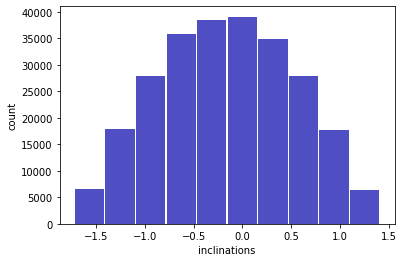

In [156]:
hist, bin_edges = np.histogram(np.pi/2 - phys_cat.incl, bins=10)
print(hist)
print(bin_edges)
plt.bar(bin_edges[:-1], hist, width=0.3, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("inclinations")
plt.show()

In [243]:
prob_detections, transit_statuses, transit_multiplicities, sn = calculate_transit_array(star_radius=phys_cat.star_radius, 
                        P=phys_cat.period, e=phys_cat.ecc, incl=phys_cat.incl, 
                        omega=phys_cat.omega, star_mass=phys_cat.star_mass, 
                        planet_radius = phys_cat.planet_radius, planet_mass = phys_cat.planet_mass,
                        cdpps = cdpps)

print(prob_detections, transit_statuses, transit_multiplicities)

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


transit durations:  0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
252291   NaN
252292   NaN
252293   NaN
252294   NaN
252295   NaN
Length: 252296, dtype: float64 0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
252291   NaN
252292   NaN
252293   NaN
252294   NaN
252295   NaN
Length: 252296, dtype: float64 0         0.232621
1         0.287363
2         0.319432
3         0.414378
4         0.550529
            ...   
252291    0.296869
252292    0.342429
252293    0.426779
252294    0.506424
252295    0.567540
Length: 252296, dtype: float64
CDPP ingredients:  103.268 0.25 0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
252291   NaN
252292   NaN
252293   NaN
252294   NaN
252295   NaN
Length: 252296, dtype: float64
number of nonzero SN:  5778
[array([0., 0., 0., ..., 0., 0., 0.])] [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [263]:
phys_cat['transit_status'] = transit_statuses[0]
transiters = phys_cat.loc[phys_cat['transit_status']==1]
transiters.groupby('target_id').count()['transit_status'].reset_index().groupby('transit_status').count().reset_index()


,transit_status,target_id
0,1,1165
1,2,280
2,3,82
3,4,23
4,5,6
5,6,1


In [220]:
obs_cat1

,target_id,star_id,period,period_err,depth,depth_err,duration,duration_err,star_mass,star_radius
0,65.0,77706.0,4.301932,0.000416,0.001497,0.000026,0.083454,0.000971,0.778,0.745
1,98.0,66894.0,120.710912,0.003452,0.000407,0.000025,0.302629,0.006763,0.837,0.870
2,113.0,22051.0,10.081561,0.002077,0.000363,0.000022,0.154530,0.004597,0.966,0.989
3,387.0,17795.0,21.456983,0.000828,0.000697,0.000012,0.264491,0.001803,1.167,1.387
4,462.0,13840.0,27.861821,0.002702,0.000225,0.000020,0.102578,0.005439,0.918,0.867
...,...,...,...,...,...,...,...,...,...,...
2064,56482.0,42623.0,8.499573,0.000618,0.001051,0.000018,0.160912,0.001335,1.048,1.059
2065,56482.0,42623.0,19.013656,0.000753,0.001277,0.000023,0.210402,0.001697,1.048,1.059
2066,56482.0,42623.0,48.988708,0.001056,0.001767,0.000036,0.238828,0.002137,1.048,1.059
2067,56482.0,42623.0,104.380900,0.000596,0.005725,0.000043,0.365634,0.001176,1.048,1.059


In [267]:
obs_cat1.groupby('target_id').count().star_id.reset_index().groupby('star_id').count().reset_index()

,star_id,target_id
0,1,1152
1,2,264
2,3,86
3,4,26
4,5,3
5,6,2


Heqqqq yeah! My detection pipeline nearly reproduces the observed catalog from He et al 2020b. Difference of 30 over 2000 planets. 

### Draw eccentricities and inclinations from AMD model

That is, draw ecc and incl from top panel of Figure 3 in Millholland et al 2021

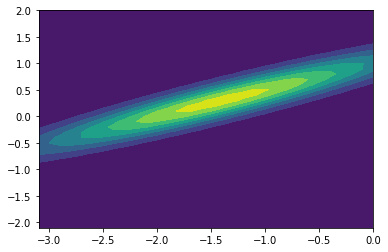

In [636]:
import scipy

x, y = np.mgrid[-3.1:0.1:.1, -2.1:2.1:.1]
pos = np.dstack((x, y))
rv = scipy.stats.multivariate_normal([-1.4, np.log10(2)], [[0.3, 0.05], [0.08, 0.3]])
rv = scipy.stats.multivariate_normal([-1.4, np.log10(2)], [[1.4, 1.4], [0.7, 0.4]])
#rv = scipy.stats.multivariate_normal([-1.4, np.log10(2)], [[600, 12.1], [42.1, 230]])
#rv = scipy.stats.multivariate_normal([-1.4, np.log10(2)], [[90, -40], [30, 40]])
#rv = scipy.stats.multivariate_normal([-1.4, np.log10(2)], [[1, 0.43], [0.52, 1]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos))
plt.show()

Looks good in linear space, but not in log space. What if, instead, I took the exponential of the covariance matrix parameters that work in linear space, and then plotted that in logspace? 

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: covariance is not positive-semidefinite.
  # This is added back by InteractiveShellApp.init_path()


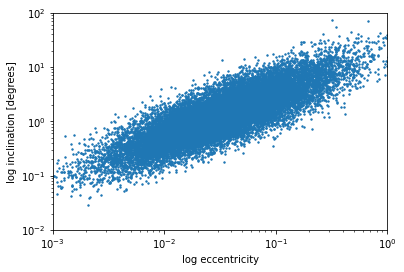

In [645]:
#center_x = 10**-1.4
#center_y = 2
center_x = -2.8 # not sure why it has to be double for me to get it centered at -1.4
center_x = -3.4 # actually, this is more accurate. I have no idea why.
center_y = np.log10(2)

mean = [center_x, center_y]
#cov = [[1, 1], [5, 10]]
#cov = [[4,1.5], [4, 0.01]]
cov = [[1.4,1.4], [0.7, 0.4]]
mvn = np.random.multivariate_normal(mean, cov, len(berger_kepler))
#x, y = mvn.T
#plt.scatter(x, y, s=2)
#plt.show()

mvln = np.exp(mvn) # go from normal to lognormal so I can present in log axes like Millholland
x, y = mvln.T
plt.scatter(x, y, s=2)
#fig2 = sns.kdeplot(x, y, legend = True, 
#                   levels=[0.5, 0.68, 0.95], colors=['blue','black','red'])
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-3, 1e0)
plt.ylim(1e-2, 1e2)
plt.xlabel('log eccentricity')
plt.ylabel('log inclination [degrees]')
plt.show()

Okay, so the assumption I'm testing is that regardless of any star or planet property, including intrinsic multiplicity, I will just randomly draw from the above distribution for eccentricity and inclination. Let's do that.

In [652]:
print(np.mean(x), np.mean(y)) # mean ecc and incl

0.062092168132382115 2.338479775003599


In [675]:
0.5-0.3*(np.log10(2e9)-8) # choose m=-0.3, b=0.5, cutoff=1e10 yrs as fiducial hyperparams

0.10969100130080561

In [789]:
def compute_prob2(x, m, b, cutoff): # adapted from Ballard et al in prep, log version
    # calculate probability of intact vs disrupted
    x = x*1e9
    if x <= 1e8: # we don't care about (nor do we have) systems before 1e8 years
        y = b

    elif (x > 1e8) & (x <= cutoff): # pre-cutoff regime
        #print(np.log10(x_elt), m, b)
        y = b + m*(np.log10(x)-8)

    elif x > cutoff: # if star is older than cutoff, use P(intact) at cutoff time
        y = b + m*(np.log10(cutoff)-8)

    if y < 0: # handle negative probabilities
        y = 0
    elif y > 1:
        y = 1
            
    return y

def calculate_transit_me_with_amd(P, star_radius, planet_radius, e, incl, omega, star_mass, cdpps, angle_flag):
    """
    accepts columns of the berger_kepler dataframe
    """
    #print(P, star_radius, planet_radius, e, incl, omega, star_mass, cdpps)
    prob_detections = []
    transit_statuses = []
    transit_multiplicities = []
    #planet_radius = 2.       
    
    # reformulate P as a in AU
    a = p_to_a(P, star_mass)
    
    # calculate impact parameters; distance units in solar radii
    b = calculate_impact_parameter(star_radius, a, e, incl, omega, angle_flag)
    
    # make sure arrays have explicitly float elements
    planet_radius = planet_radius.astype(float)
    star_radius = star_radius.astype(float)
    b = b.astype(float)
    a = a.astype(float)
    incl = incl.astype(float)
    e = e.astype(float)
    omega = omega.astype(float)
    cdpps = cdpps.astype(float)
    P = P.astype(float)
    print("b: ", b)
    # calculate transit durations using Winn 2011 formula; same units as period
    #tdur = calculate_transit_duration(P, solar_radius_to_au(star_radius), 
    #                        earth_radius_to_au(planet_radius), b, a, incl, e, omega)
    # Matthias's planet params are in solar units
    tdur = calculate_transit_duration(P, solar_radius_to_au(star_radius), 
                            earth_radius_to_au(planet_radius), b, a, incl, e, omega, angle_flag)
    print("tdur: ", tdur)
    tdur_paw = calculate_transit_duration_paw(P, solar_radius_to_au(star_radius), 
                            earth_radius_to_au(planet_radius), b, a, incl, e, omega)
    
    tdur_he = calculate_transit_duration_he(P, solar_radius_to_au(star_radius),
                                           earth_radius_to_au(planet_radius), a)
    #print("transit durations: ", tdur, tdur_paw, tdur_he)
    
    # calculate CDPP by drawing from Kepler dataset relation with star radius
    #cdpp = [draw_cdpp(sr, berger_kepler) for sr in star_radius]
    
    # calculate SN based on Eqn 4 in Christiansen et al 2012
    sn = calculate_sn(P, planet_radius, star_radius, cdpps, tdur, unit_test_flag=False)
    print("number of nonzero SN: ", len(np.where(sn>0)[0]))
    
    # calculate Fressin detection probability based on S/N
    #ts2 = [1 if sn_elt >= 7.1 else 0 for sn_elt in sn] # S/N threshold before Fressin et al 2013
    #prob_detection = np.array([0.1*(sn_elt-6) for sn_elt in sn]) # S/N threshold using Fressin et al 2013
    #prob_detection[np.isnan(prob_detection)] = 0 # replace NaNs with zeros
    prob_detection = 0.1*(sn-6) # vectorize
    prob_detection = np.where(prob_detection < 0., 0., prob_detection) # replace negative probs with zeros
    # actually, replace all probabilities under 5% with 5% to avoid over-penalizing models which terminate at 0% too early
    prob_detection = np.where(prob_detection > 1, 1, prob_detection) # replace probs > 1 with just 1
    prob_detections.append(prob_detection)
    
    # sample transit status and multiplicity based on Fressin detection probability
    #transit_status = [ts1_elt * ts2_elt for ts1_elt, ts2_elt in zip(ts1, ts2)]
    transit_status = [np.random.choice([1, 0], p=[pd, 1-pd]) for pd in prob_detection]
    transit_statuses.append(transit_status)
    transit_multiplicities.append(len([ts for ts in transit_status if ts == 1]))
    #transit_multiplicities.append(len([param for param in b if np.abs(param) <= 1.]))
    
    return prob_detections, transit_statuses, transit_multiplicities, sn

def model_with_amd(star_age, df):
    m = -0.3
    b = 0.5
    cutoff = 1e10 # yrs
    periods = [] # the column upon which we'll explode berger_kepler to make berger_kepler_planets
    num_planets_all = [] # intrinsic planets
    intacts = 0
    midplanes = np.random.uniform(-np.pi/2,np.pi/2,len(df))
    
    for age in star_age:
        # sometimes make more than one planet per system
        prob = compute_prob2(age, m, b, cutoff)
        #print(age, prob)
        
        intact_flag = np.random.choice(['intact', 'disrupted'], p=[prob, 1-prob])
        if intact_flag == 'intact':
            intacts += 1
            # young system has 5 or 6 planets
            num_planets = random.choice([5, 6]) 

            # draw period from loguniform distribution from 2 to 300 days
            P = np.array(loguniform.rvs(2, 300, size=num_planets)) 
            periods.append(P)

        elif intact_flag == 'disrupted':
            # old system has 1 or 2 planets
            num_planets = random.choice([1, 2]) 

            # draw period from loguniform distribution from 2 to 300 days
            P = np.array(loguniform.rvs(2, 300, size=num_planets)) 
            periods.append(P)

        num_planets_all.append(num_planets)
    
    df['midplanes'] = midplanes
    df['P'] = periods
    berger_kepler_planets = df.explode('P')
    #print(berger_kepler_planets)
    print("intacts: ", intacts)
    
    # draw longitudes of periastron
    omega = np.random.uniform(0,2*np.pi,len(berger_kepler_planets))
    berger_kepler_planets['omega'] = omega
    
    # draw ecc and incl the max AMD way, eyeball edition
    center_x = -3.4 # actually, this is more accurate. I have no idea why.
    center_y = np.log10(2)
    mean = [center_x, center_y]
    cov = [[1.4,1.4], [0.7, 0.4]]
    mvn = np.random.multivariate_normal(mean, cov, len(berger_kepler_planets))
    mvln = np.exp(mvn) # go from normal to lognormal so I can present in log axes like Millholland
    ecc, incl = mvln.T
    berger_kepler_planets['ecc'] = ecc
    berger_kepler_planets['incl'] = incl*(np.pi/180)+berger_kepler_planets['midplanes']
    berger_kepler_planets['planet_radius'] = 2.
    print("mean ecc and incl: ", np.mean(berger_kepler_planets['ecc']), berger_kepler_planets['incl'])
    
    prob_detections, transit_statuses, transit_multiplicities, sn = calculate_transit_me_with_amd(berger_kepler_planets.P, 
                            berger_kepler_planets.st_radius, berger_kepler_planets.planet_radius,
                            berger_kepler_planets.ecc, 
                            berger_kepler_planets.incl, 
                            berger_kepler_planets.omega, berger_kepler_planets.iso_mass,
                            berger_kepler_planets.rrmscdpp06p0, angle_flag=True)
    
    berger_kepler_planets['transit_status'] = transit_statuses[0]
    berger_kepler_planets['prob_detections'] = prob_detections[0]
    berger_kepler_planets['sn'] = sn
    return berger_kepler_planets

def model_og(star_age, df):
    m = -0.3
    b = 0.5
    cutoff = 1e10 # yrs
    periods = [] # the column upon which we'll explode berger_kepler to make berger_kepler_planets
    num_planets_all = [] # intrinsic planets
    eccs = []
    incls = []
    intacts = 0
    
    for age in star_age:
        # sometimes make more than one planet per system
        prob = compute_prob2(age, m, b, cutoff)
        #print(age, prob)
        
        # midplane
        midplane = np.random.uniform(-np.pi/2,np.pi/2,1)
        
        intact_flag = np.random.choice(['intact', 'disrupted'], p=[prob, 1-prob])
        if intact_flag == 'intact':
            intacts += 1
            # young system has 5 or 6 planets
            num_planets = random.choice([5, 6]) 

            # draw period from loguniform distribution from 2 to 300 days
            P = np.array(loguniform.rvs(2, 300, size=num_planets)) 
            periods.append(P)
            
            # draw ecc and incl
            sigma = np.pi/90 # 2 degrees, per Fig 6 in Fabrycky 2012
            incl = np.random.normal(midplane, sigma, num_planets)
            incls.append(incl)
            ecc = calculate_eccentricity(num_planets)
            eccs.append(ecc)

        elif intact_flag == 'disrupted':
            # old system has 1 or 2 planets
            num_planets = random.choice([1, 2]) 

            # draw period from loguniform distribution from 2 to 300 days
            P = np.array(loguniform.rvs(2, 300, size=num_planets)) 
            periods.append(P)

            # draw ecc and incl
            sigma = np.pi/22.5 # 2 degrees, per Fig 6 in Fabrycky 2012
            incl = np.random.normal(midplane, sigma, num_planets)
            incls.append(incl)
            ecc = calculate_eccentricity(num_planets)
            eccs.append(ecc)

        num_planets_all.append(num_planets)
    
    df['P'] = periods
    berger_kepler_planets = df.explode('P')
    #print(berger_kepler_planets)
    print("intacts: ", intacts)
    
    # draw longitudes of periastron
    omega = np.random.uniform(0,2*np.pi,len(berger_kepler_planets))
    berger_kepler_planets['omega'] = omega
    
    eccs = np.asarray([item for ecc_elt in eccs for item in ecc_elt])
    incls = np.asarray([item for incl_elt in incls for item in incl_elt])
    #print(len(incls), len(eccs), len(omega))
    #print(np.pi/2 - incls)
    berger_kepler_planets['ecc'] = eccs
    berger_kepler_planets['incl'] = incls
    berger_kepler_planets['planet_radius'] = 2.
    print("ecc: ", berger_kepler_planets['ecc'])
    print("incl: ", berger_kepler_planets['incl'])
    print("mean ecc and incl: ", np.mean(berger_kepler_planets['ecc']), np.mean(berger_kepler_planets['incl']))
    print(berger_kepler_planets)
    
    prob_detections, transit_statuses, transit_multiplicities, sn = calculate_transit_me_with_amd(berger_kepler_planets.P, 
                            berger_kepler_planets.st_radius, berger_kepler_planets.planet_radius,
                            berger_kepler_planets.ecc, 
                            berger_kepler_planets.incl, 
                            berger_kepler_planets.omega, berger_kepler_planets.iso_mass,
                            berger_kepler_planets.rrmscdpp06p0, angle_flag=True)
    
    berger_kepler_planets['transit_status'] = transit_statuses[0]
    berger_kepler_planets['prob_detections'] = prob_detections[0]
    berger_kepler_planets['sn'] = sn
    return berger_kepler_planets

def model_van_eylen(star_age, df, model_flag):
    m = -0.3
    b = 0.5
    cutoff = 1e10 # yrs
    periods = [] # the column upon which we'll explode berger_kepler to make berger_kepler_planets
    num_planets_all = [] # intrinsic planets
    eccs = []
    incls = []
    intacts = 0
    
    for age in star_age:
        # sometimes make more than one planet per system
        prob = compute_prob2(age, m, b, cutoff)
        #print(age, prob)
        
        # midplane
        midplane = np.random.uniform(-np.pi/2,np.pi/2,1)
        
        intact_flag = np.random.choice(['intact', 'disrupted'], p=[prob, 1-prob])
        if intact_flag == 'intact':
            intacts += 1
            # young system has 5 or 6 planets
            num_planets = random.choice([5, 6]) 

            # draw period from loguniform distribution from 2 to 300 days
            P = np.array(loguniform.rvs(2, 300, size=num_planets)) 
            periods.append(P)
            
            # draw ecc and incl
            sigma = np.pi/90 # 2 degrees, per Fig 6 in Fabrycky 2012
            incl = np.random.normal(midplane, sigma, num_planets)
            incls.append(incl)
            #ecc = calculate_eccentricity(num_planets)
            ecc = draw_eccentricity_van_eylen(model_flag, num_planets)
            eccs.append(ecc)

        elif intact_flag == 'disrupted':
            # old system has 1 or 2 planets
            num_planets = random.choice([1, 2]) 

            # draw period from loguniform distribution from 2 to 300 days
            P = np.array(loguniform.rvs(2, 300, size=num_planets)) 
            periods.append(P)

            # draw ecc and incl
            sigma = np.pi/22.5 # 8 degrees, per Fig 6 in Fabrycky 2012
            incl = np.random.normal(midplane, sigma, num_planets)
            incls.append(incl)
            #ecc = calculate_eccentricity(num_planets)
            ecc = draw_eccentricity_van_eylen(model_flag, num_planets)
            eccs.append(ecc)

        num_planets_all.append(num_planets)
    
    df['P'] = periods
    berger_kepler_planets = df.explode('P')
    #print(berger_kepler_planets)
    print("intacts: ", intacts)
    
    # draw longitudes of periastron
    omega = np.random.uniform(0,2*np.pi,len(berger_kepler_planets))
    berger_kepler_planets['omega'] = omega
    
    eccs = np.asarray([item for ecc_elt in eccs for item in ecc_elt])
    incls = np.asarray([item for incl_elt in incls for item in incl_elt])
    #print(len(incls), len(eccs), len(omega))
    #print(np.pi/2 - incls)
    berger_kepler_planets['ecc'] = eccs
    berger_kepler_planets['incl'] = incls
    berger_kepler_planets['planet_radius'] = 2.
    print("ecc: ", berger_kepler_planets['ecc'])
    print("incl: ", berger_kepler_planets['incl'])
    print("mean ecc and incl: ", np.mean(berger_kepler_planets['ecc']), np.mean(berger_kepler_planets['incl']))
    print(berger_kepler_planets)
    
    prob_detections, transit_statuses, transit_multiplicities, sn = calculate_transit_me_with_amd(berger_kepler_planets.P, 
                            berger_kepler_planets.st_radius, berger_kepler_planets.planet_radius,
                            berger_kepler_planets.ecc, 
                            berger_kepler_planets.incl, 
                            berger_kepler_planets.omega, berger_kepler_planets.iso_mass,
                            berger_kepler_planets.rrmscdpp06p0, angle_flag=True)
    
    berger_kepler_planets['transit_status'] = transit_statuses[0]
    berger_kepler_planets['prob_detections'] = prob_detections[0]
    berger_kepler_planets['sn'] = sn
    return berger_kepler_planets

def draw_inclination_van_eylen(model_flag, num_planets):
    if model_flag=='rayleigh':
        sigma_single = 0.24
        sigma_multi = 0.061
        if num_planets==1:
            sigma = sigma_single
        elif num_planets>1:
            sigma = sigma_multi
            
        draw = np.random.rayleigh(sigma, num_planets)
        print(draw)
        
    return draw

# draw eccentricities using Limbach & Turner 2014 CDFs relating e to multiplicity
limbach = pd.read_csv(path+'limbach_cdfs.txt', header=0, sep='\s{2,20}') # space-agnostic separator
def calculate_eccentricity(multiplicity):
    # draw eccentricities using Limbach & Turner 2014 CDFs relating e to multiplicity
    values = np.random.rand(multiplicity) # draw an eccentricity per planet
    if multiplicity==1:
        value_bins = np.searchsorted(limbach['1'], values) # return positions in cdf vector where random values should go
    elif multiplicity==2:
        value_bins = np.searchsorted(limbach['2'], values) # return positions in cdf vector where random values should go
    elif multiplicity==5:
        value_bins = np.searchsorted(limbach['5'], values) # return positions in cdf vector where random values should go
    elif multiplicity==6:
        value_bins = np.searchsorted(limbach['6'], values) # return positions in cdf vector where random values should go
    random_from_cdf = np.logspace(-2,0,101)[value_bins] # select x_d positions based on these random positions
    
    return random_from_cdf

berger_kepler_planets = model_with_amd(berger_kepler.iso_age, berger_kepler)


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/ipykernel_launcher.py:344: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


intacts:  2337
mean ecc and incl:  0.06202421542249475 0        1.089280
1        0.276885
1        0.298534
2        1.461042
2        1.573332
           ...   
19966    0.175965
19967    0.879380
19967    0.905216
19968   -1.119899
19968   -1.082686
Name: incl, Length: 39319, dtype: float64
b:  0         9.962402
1        10.907059
1         2.324263
2        67.787091
2        19.407014
           ...    
19966    13.237838
19967    39.038456
19967     6.249978
19968   -27.580167
19968   -18.762376
Length: 39319, dtype: float64
tdur:  0       NaN
1       NaN
1       NaN
2       NaN
2       NaN
         ..
19966   NaN
19967   NaN
19967   NaN
19968   NaN
19968   NaN
Length: 39319, dtype: float64
CDPP ingredients:  0         46.445
1         66.041
1         66.041
2         41.383
2         41.383
          ...   
19966    145.049
19967    388.023
19967    388.023
19968    223.042
19968    223.042
Name: rrmscdpp06p0, Length: 39319, dtype: float64 0.25 0       NaN
1       NaN
1       

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/ipykernel_launcher.py:137: RuntimeWarning: covariance is not positive-semidefinite.
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [784]:
draw_inclination_van_eylen('rayleigh', 2)

[0.01648382 0.06984191]


array([0.01648382, 0.06984191])

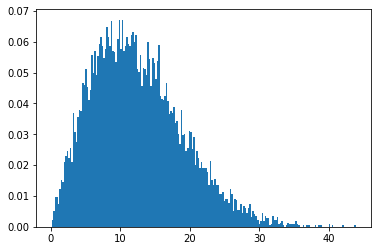

In [780]:
values = plt.hist(np.random.rayleigh(10, 10000), bins=200, density=True)

          kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
27      1295531  2MASS J19262003+3655059  6767       70.0     -101.0  4.167   
27      1295531  2MASS J19262003+3655059  6767       70.0     -101.0  4.167   
71      1572948  2MASS J19251859+3707361  6606      181.0     -250.0  4.071   
82      1575888  2MASS J19274322+3709274  6381      155.0     -194.0  4.038   
85      1576662  2MASS J19281989+3707283  5846       78.0      -78.0  3.730   
...         ...                      ...   ...        ...        ...    ...   
19869  12552890  2MASS J19121714+5131102  6438      162.0     -179.0  3.894   
19869  12552890  2MASS J19121714+5131102  6438      162.0     -179.0  3.894   
19890  12599904  2MASS J19155980+5140393  6640      179.0     -179.0  3.655   
19948  12783625  2MASS J19180714+5201567  6258      159.0     -159.0  3.887   
19954  12833566  2MASS J19175224+5211530  6456      182.0     -228.0  3.659   

       logg_err1  logg_err2  feh_x  feh_err1  ...  

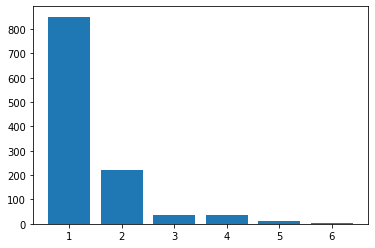

In [790]:
transiters_berger_kepler = berger_kepler_planets.loc[berger_kepler_planets['transit_status']==1]
#print(berger_kepler_planets)
print(transiters_berger_kepler)
transit_multiplicity = transiters_berger_kepler.groupby('kepid').count()['transit_status'].reset_index().groupby('transit_status').count().reset_index()
print(transit_multiplicity)
plt.bar(transit_multiplicity.transit_status, transit_multiplicity.kepid)
plt.show()


### Construction Only Below

This is a partial block to troubleshoot parts of the detection pipeline.

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)


252296
5688
[    1     0     1     0     2     2     1     5     4    12    17    31
    37    56    68    93   144   168   222   305   359   443   543   623
   738   823   996  1166  1382  1552  1717  2067  2285  2654  2948  3402
  3806  4149  4816  5513  6390  7461  8881 10617 13376 16666 18781 18904
 17246 13499 10879  8853  7516  6528  5619  4809  4350  3793  3375  2939
  2589  2256  2052  1827  1553  1366  1225  1001   884   761   619   526
   449   344   264   244   205   127   122    81    47    35    31    22
    13     4     4     4     4     0     1     0     1     0     1     0
     0     0     0     1]
[-306.26669728 -299.75944948 -293.25220169 -286.74495389 -280.2377061
 -273.7304583  -267.2232105  -260.71596271 -254.20871491 -247.70146712
 -241.19421932 -234.68697152 -228.17972373 -221.67247593 -215.16522814
 -208.65798034 -202.15073254 -195.64348475 -189.13623695 -182.62898916
 -176.12174136 -169.61449356 -163.10724577 -156.59999797 -150.09275018
 -143.58550238 -137.0782

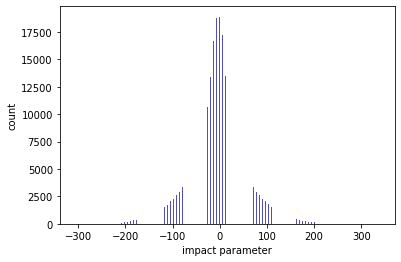

number of nonzero SN:  849
number of SN>7.1:  749


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [230]:
def calculate_transit_array2(star_radius, P, e, incl, omega, star_mass, planet_radius, planet_mass):
    """
    accepts columns of the physical_catalogN dataframe
    """
    
    prob_detections = []
    transit_statuses = []
    transit_multiplicities = []
    
    # reformulate P as a in AU
    a = p_to_a(P, star_mass)
    
    # calculate impact parameters; distance units in solar radii
    b = calculate_impact_parameter(star_radius, a, e, incl, omega, angle_flag=False)
    
    # calculate transit durations using Winn 2011 formula; same units as period
    tdur = calculate_transit_duration(P, solar_radius_to_au(star_radius), 
                            solar_radius_to_au(planet_radius), b, a, incl, e, omega)
    
    tdur_paw = calculate_transit_duration_paw(P, solar_radius_to_au(star_radius), 
                            solar_radius_to_au(planet_radius), b, a, incl, e, omega)
    
    tdur_he = calculate_transit_duration_he(P, solar_radius_to_au(star_radius),
                                           solar_radius_to_au(planet_radius), a)
    #print("transit durations: ", tdur, tdur_paw, tdur_he)
    print(len(b))
    print(len(np.where(np.abs(b)<1.)[0]))
    
    hist, bin_edges = np.histogram(b, bins=100)
    print(hist)
    print(bin_edges)
    plt.bar(bin_edges[:-1], hist, width=1, color='#0504aa',alpha=0.7)
    plt.ylabel("count")
    plt.xlabel("impact parameter")
    plt.show()
    
    # calculate SN based on Eqn 4 in Christiansen et al 2012
    sn = calculate_sn(P, planet_radius, star_radius, cdpps, tdur, unit_test_flag=False)
    print("number of nonzero SN: ", len(np.where(sn>0)[0]))
    print("number of SN>7.1: ", len(np.where(sn>7.1)[0]))
    
calculate_transit_array2(star_radius=phys_cat.star_radius, 
                        P=phys_cat.period, e=phys_cat.ecc, incl=phys_cat.incl, 
                        omega=phys_cat.omega, star_mass=phys_cat.star_mass, 
                        planet_radius = phys_cat.planet_radius, planet_mass = phys_cat.planet_mass)



In [134]:
print(prob_detections, transit_statuses, transit_multiplicities)

[array([0., 0., 0., ..., 0., 0., 0.])] [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [82]:
phys_cat

,target_id,star_id,planet_mass,planet_radius,clusterid,period,ecc,incl,omega,asc_node,mean_anom,incl_invariable,asc_node_invariable,star_mass,star_radius
0,1.0,32722.0,0.000024,0.036591,1.0,13.033967,0.012430,1.140914,-2.614705,5.570762,1.156993,0.029773,4.686570,1.031,1.320
1,1.0,32722.0,0.000012,0.023100,1.0,24.570980,0.024209,1.101595,1.394187,5.585773,4.613298,0.033668,2.525758,1.031,1.320
2,1.0,32722.0,0.000010,0.017899,1.0,33.749414,0.026713,1.142476,-1.412422,5.613070,2.385974,0.014541,5.556195,1.031,1.320
3,1.0,32722.0,0.000042,0.025463,1.0,73.674940,0.022134,1.138698,-0.665105,5.619659,5.347568,0.017345,0.991324,1.031,1.320
4,1.0,32722.0,0.000039,0.031153,1.0,172.771079,0.023713,1.127650,-2.214418,5.596840,0.589863,0.006359,2.375161,1.031,1.320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252291,86759.0,34287.0,0.000009,0.012245,1.0,51.553007,0.043211,2.002685,-1.826563,3.131970,3.790159,0.038448,6.068412,1.045,1.070
252292,86759.0,34287.0,0.000009,0.022599,1.0,79.116959,0.054646,2.057380,2.302173,3.132922,1.349664,0.018547,3.535483,1.045,1.070
252293,86759.0,34287.0,0.000017,0.025012,2.0,153.167410,0.041132,2.059121,-0.184505,3.124563,4.845719,0.023827,3.795498,1.045,1.070
252294,86759.0,34287.0,0.000027,0.017018,2.0,255.917742,0.049225,2.033844,0.999469,3.153026,3.442352,0.012532,1.035027,1.045,1.070


In [79]:
calculate_transit(star_radius=star_radius, P=P, e=0.4, incl=(80/90)*np.pi/2, omega=np.pi/2, star_mass=star_mass)
calculate_transit(star_radius=star_radius, P=P, e=0., incl=0., omega=0., star_mass=star_mass)

transit durations:  0.9047646480270792 0.1543041143696468 0.23262106131375507
transit durations:  0.23597957381202503 0.23597957381202503 0.23262106131375507


How did He et al 2020b calculate their transit durations?

In [66]:
index = 65.0
phys_cat_sub = phys_cat.loc[phys_cat['target_id']==index].reset_index().iloc[0]
star_radius = phys_cat_sub.star_radius
P = phys_cat_sub.period 
e = phys_cat_sub.ecc
incl = phys_cat_sub.incl
omega = phys_cat_sub.omega
star_mass = phys_cat_sub.star_mass

print("star properties: ", star_radius, P, e, incl, omega, star_mass)
calculate_transit(star_radius=star_radius, P=P, e=e, incl=incl, omega=omega, star_mass=star_mass)

star properties:  0.745 4.301520897245167 0.4007481803153485 1.6182565132456368 -0.6193679582234087 0.778
Winn args:  1.0238154184258759 -1.570685778699825 1.1939524275524047
PAW args:  0.0035471110522506026 0.07451705799527342 1.1939524275524047
transit durations:  nan 0.12193198186235885 0.09965663046515319


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arcsin


In [67]:
print(phys_cat.loc[phys_cat['target_id']==index])
print(obs_cat1.loc[obs_cat1['target_id']==index])

     target_id  star_id  planet_mass  planet_radius  clusterid      period  \
154       65.0  77706.0     0.000021       0.027079        1.0    4.301521   
155       65.0  77706.0     0.000008       0.015583        1.0   38.773554   
156       65.0  77706.0     0.000008       0.019510        1.0  161.447259   

          ecc      incl     omega  asc_node  mean_anom  incl_invariable  \
154  0.400748  1.618257 -0.619368  4.149292   3.844818         0.106377   
155  0.278884  1.737046  2.508759  4.051277   0.581802         0.097457   
156  0.227099  1.597641  1.359497  3.967424   1.911765         0.088150   

     asc_node_invariable  star_mass  star_radius  
154             1.500445      0.778        0.745  
155             4.042134      0.778        0.745  
156             1.221291      0.778        0.745  
   target_id  star_id    period  period_err     depth  depth_err  duration  \
0       65.0  77706.0  4.301932    0.000416  0.001497   0.000026  0.083454   

   duration_err  star_mas

In [70]:
(4.301521/np.pi)/(0.745/p_to_a(4.301521, 0.778))

0.08748528163012886

In [72]:
print(phys_cat.loc[phys_cat['target_id']==index])
print(obs_cat1.loc[obs_cat1['target_id']==index])

        target_id  star_id  planet_mass  planet_radius  clusterid      period  \
164549    56482.0  42623.0     0.000008       0.030040        1.0    5.853836   
164550    56482.0  42623.0     0.000015       0.033781        1.0    8.503248   
164551    56482.0  42623.0     0.000018       0.037236        1.0   19.004638   
164552    56482.0  42623.0     0.000016       0.043793        1.0   48.996596   
164553    56482.0  42623.0     0.000036       0.078855        1.0  104.370603   
164554    56482.0  42623.0     0.000047       0.042455        1.0  224.209444   

             ecc      incl     omega  asc_node  mean_anom  incl_invariable  \
164549  0.033694  1.546995  2.784011  2.900938   0.386899         0.026881   
164550  0.035996  1.560738 -0.435327  2.897333   2.807502         0.020342   
164551  0.033014  1.562260 -1.868247  2.905837   1.995472         0.012218   
164552  0.016546  1.581228 -2.931526  2.888144   5.625495         0.029979   
164553  0.020179  1.569588  0.472232  2.92

In [80]:
index = 56482.0
for i in range(6):
    phys_cat_sub = phys_cat.loc[phys_cat['target_id']==index].reset_index().iloc[i]
    star_radius = phys_cat_sub.star_radius
    P = phys_cat_sub.period 
    e = phys_cat_sub.ecc
    incl = phys_cat_sub.incl
    omega = phys_cat_sub.omega
    star_mass = phys_cat_sub.star_mass

    #print("star properties: ", star_radius, P, e, incl, omega, star_mass)
    calculate_transit(star_radius=star_radius, P=P, e=e, incl=incl, omega=omega, star_mass=star_mass)
    

transit durations:  nan 0.1427302652469024 0.14214278439982372
transit durations:  nan 0.16577927967531453 0.1609803747745403
transit durations:  nan 0.21898250884260712 0.2104737061329734
transit durations:  nan 0.2854032642021182 0.2886024064851071
transit durations:  nan 0.34217971500613104 0.3713391246509029
transit durations:  nan 0.35743529774240135 0.47914020325306433


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arcsin
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arcsin
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arcsin
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arcsin
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arcsin
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arcsin


This is where I dive back into CDPP land to see how He et al 2020b and I treat CDPP and S/N differently. Apparently there's not much of a difference, despite me using a constant tcdpp of 6hrs/24hrs. 

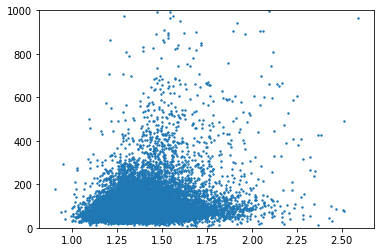

In [85]:
path = '/Users/chris/Desktop/sculpting/'
berger_kepler = pd.read_csv(path+'berger_kepler_stellar17.csv') # crossmatched with Gaia via Bedell
plt.scatter(berger_kepler.iso_mass, berger_kepler.rrmscdpp06p0, s=2)
plt.ylim(0, 1000)
plt.show()


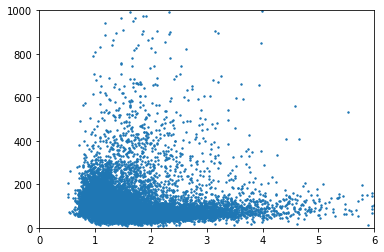

In [90]:
plt.scatter(berger_kepler.st_radius, berger_kepler.rrmscdpp06p0, s=2)
plt.ylim(0, 1000)
plt.xlim(0, 6)
plt.show()

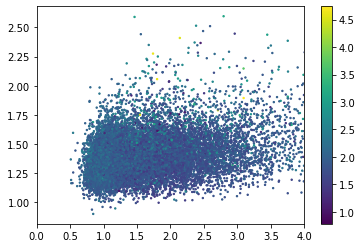

In [96]:
plt.scatter(berger_kepler.st_radius, berger_kepler.iso_mass, s=2, c=np.log10(berger_kepler.rrmscdpp06p0))
plt.colorbar()
plt.xlim(0, 4)
plt.show()

In [ ]:
def kde_func(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x) # constant bandwidth so imbalance in sample size doesn't drive distribution
    return kde.evaluate(x_grid)

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    #print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    #print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)


Calculate CDPP for simulated systems a la He et al 2020b

In [100]:
### constants
cdpp_durations = [1.5,2.,2.5,3.,3.5,4.5,5.,6.,7.5,9.,10.5,12.,12.5,15.]
#duration_symbols = [rrmscdpp01p5, :rrmscdpp02p0,:rrmscdpp02p5,:rrmscdpp03p0,
#                    rrmscdpp03p5,:rrmscdpp04p5,:rrmscdpp05p0,:rrmscdpp06p0,
#                    :rrmscdpp07p5,:rrmscdpp09p0,:rrmscdpp10p5,:rrmscdpp12p0,:rrmscdpp12p5,:rrmscdpp15p0 ]
kepler_exp_time_internal  =  6.019802903/(24*60*60)    # https://archive.stsci.edu/kepler/manuals/archive_manual.pdf
kepler_read_time_internal = 0.5189485261/(24*60*60)    # https://archive.stsci.edu/kepler/manuals/archive_manual.pdf
num_exposures_per_LC = 270
LC_integration_time = kepler_exp_time_internal*num_exposures_per_LC
LC_read_time = kepler_read_time_internal*num_exposures_per_LC
LC_duration = LC_integration_time +  LC_read_time
print(LC_duration)

def interpolate_cdpp_to_duration_lookup_cdpp(duration):
    """
    He et al 2020b's CDPP calculator for their simulated planets
    """
    duration_in_hours = duration*24.0
    dur_idx = np.searchsorted(cdpp_durations,duration_in_hours)   # cdpp_durations is defined in constants.jl
    def get_cdpp(i):
        return 1.0e-6*np.sqrt((cdpp_durations[i]/24.0)/LC_duration)*star_table(t,duration_symbols[i])

    if dur_idx <= 0:
        cdpp = get_cdpp(1)
    elif dur_idx==length(cdpp_durations) & (duration_in_hours >= cdpp_durations[end]): # Should be 15 cdpp_durations
        cdpp = get_cdpp(length(cdpp_durations))
    else:
        w = ((duration_in_hours)-cdpp_durations[dur_idx]) / (cdpp_durations[dur_idx+1]-cdpp_durations[dur_idx])
        cdpp = w*get_cdpp(dur_idx+1) + (1-w)*get_cdpp(dur_idx)
    
    return cdpp

0.020433598215937505


In [101]:
tobs = 365*3.5 # days; time spanned observing the target; set to 3.5 years, or the length of Kepler mission
f0 = 0.92
print(tobs*f0)

1175.3
